In [97]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import minimize 
from scipy.stats import linregress 

class OperatingPoint:
    def __init__(self, P_pu: float, Q_pu: float, V_pu: float):
        self.P_pu = P_pu
        self.Q_pu = Q_pu
        self.V_pu = V_pu 
        
    def get_point(self): 
        return self.P_pu, self.Q_pu, self.V_pu
    
    def get_current(self, give_angle=False): 
        I = np.sqrt(self.P_pu**2 + self.Q_pu**2)/self.V_pu
        if give_angle: 
            if self.P_pu == 0 and self.Q_pu == 0: 
                phi = 0
            elif self.P_pu == 0 and not self.Q_pu == 0: 
                phi = np.pi/2 * np.sign(self.Q_pu)
            else: 
                phi = np.arctan(self.Q_pu/self.P_pu)
            return I, phi
        else: 
            return I
            
class SaturationModel: 
    def __init__(self, bv, C, n1, k1): 
        self.bv = bv
        self.C = C
        self.n1 = n1
        self.k1 = k1 
        
    def calc_ifd(self, Xq, Xd, Xp, Ra, Vt, P, Q) -> float: 
        ia = np.sqrt(P**2 + Q**2)/Vt
        if P == 0 and Q == 0: 
            phi = 0
        elif P == 0 and not Q == 0: 
            phi = np.pi/2 * np.sign(Q)
        else: 
            phi = np.arctan(Q/P) #Phase angle between terminal voltage and armature current
        delta = np.arctan(ia*(Xq*np.cos(phi)-(Ra*np.sin(phi)))/(Vt+(Ra*ia*np.cos(phi))+Xq*ia*np.sin(phi))) #Power load angle 
        egu = Vt*np.cos(delta) + (Ra*ia*np.cos(delta+phi)) + Xd*ia*np.sin(delta+phi) 
        th = np.arctan(ia*(Xp*np.cos(phi) - Ra*np.sin(phi)) / (Vt + (Ra*ia*np.cos(phi)) + Xp*ia*np.sin(phi)) ) #Potiervinkel 
        ep = Vt*np.cos(th) + (Ra*ia*np.cos(th+phi)) + Xp*ia*np.sin(th+phi) 
        ifu = egu/self.bv #Field current ved luftgapslinje 
        ep_bool = ep > 0.55 #Lager en array av True eller False (1 eller 0) slik at ifs kan lett regnes ut av i neste linje i mange tilfeller samtidig
        ifs = ((ep + self.C*ep**self.n1)*self.k1 - ep/self.bv) * ep_bool #Field inkludert saturation
        ifd = (ifu + ifs) 
        return ifd, delta, egu

In [98]:
#Known values from Åbjøra: 
Sn_mva = 103 #MVA 
Vn_kV = 11 # kV
cos_phi = 0.9 
eta_n = 0.98834 #Nominal efficiency 

Ia_n = 5406 #Amp 
If_n = 1065 #Amp 
If_base = 525.15 #Amp

Zb = Vn_kV**2/Sn_mva
Ra = 0.002
Xd = 1.087
Xq = 0.676
Xp = 0.141

#Losses at nominal operating point:
P_nom = 0.9 
Q_nom = 0.436
V_nom = 1.0
P_f_pu = 173.65 / (Sn_mva*1000) #kW -> pu
P_ex_pu = 15.88 / (Sn_mva*1000) #kW -> pu
P_br_pu = 2.13 / (Sn_mva*1000) #kW -> pu
P_a_pu = 187.46 / (Sn_mva*1000) #kW -> pu
P_s_pu = 89.16 / (Sn_mva*1000) #kW -> pu
P_c_pu = 211.92 / (Sn_mva*1000) #kW -> pu
P_be_pu = 240.90 / (Sn_mva*1000) #kW -> pu
P_wf_pu = 172.92 / (Sn_mva*1000) #kW -> pu

P_stator = P_a_pu + P_s_pu
P_rotor = P_f_pu + P_ex_pu + P_br_pu
P_constant = P_c_pu + P_be_pu + P_wf_pu

P_loss = P_f_pu + P_ex_pu + P_br_pu + P_a_pu + P_s_pu + P_c_pu + P_be_pu + P_wf_pu
P_loss*Sn_mva*1000

1094.02

In [99]:
# Calculate a stray resistance equivalent to the stray loss in the stator
R_stator = P_stator/((Ia_n/Ia_n)**2) #Ignore Ra given from the data sheet. 

#Testing for different operating points: 
OP1 = OperatingPoint(0.9, 0.436, 1.0) 
OP2 = OperatingPoint(0.675, 0.327, 1.0) 
OP3 = OperatingPoint(0.45, 0.218, 1.0) 

P_stator_1 = R_stator*OP1.get_current()**2
P_stator_2 = R_stator*OP2.get_current()**2
P_stator_3 = R_stator*OP3.get_current()**2

P_stator_1_real = (187.46 + 89.16)/(Sn_mva*1000)
P_stator_2_real = (105.45 + 50.15)/(Sn_mva*1000)
P_stator_3_real = (46.86 + 22.30 )/(Sn_mva*1000)

print(f"1: Deviation of {P_stator_1 - P_stator_1_real} pu")
print(f"2: Deviation of {P_stator_2 - P_stator_2_real} pu")
print(f"3: Deviation of {P_stator_3 - P_stator_3_real} pu")

1: Deviation of 2.5782058252427423e-07 pu
2: Deviation of 1.328881553399816e-07 pu
3: Deviation of 1.5911456310727448e-08 pu


In [4]:
def calc_ifd(Ra, Xd, Xq, Xp, Vt, P, Q): 
    ia = np.sqrt(P**2 + Q**2)/Vt
    if P == 0 and Q == 0: 
        phi = 0
    elif P == 0 and not Q == 0: 
        phi = np.pi/2 * np.sign(Q)
    else: 
        phi = np.arctan(Q/P) #Phase angle between terminal voltage and armature current
    delta = np.arctan(ia*(Xq*np.cos(phi)-(Ra*np.sin(phi)))/(Vt+(Ra*ia*np.cos(phi))+Xq*ia*np.sin(phi))) #Power load angle 
    egu = Vt*np.cos(delta) + (Ra*ia*np.cos(delta+phi)) + Xd*ia*np.sin(delta+phi) 
    th = np.arctan(ia*(Xp*np.cos(phi) - Ra*np.sin(phi)) / (Vt + (Ra*ia*np.cos(phi)) + Xp*ia*np.sin(phi)) ) #Potiervinkel 
    ep = Vt*np.cos(th) + (Ra*ia*np.cos(th+phi)) + Xp*ia*np.sin(th+phi) 
    return egu, ep 
    # ifu = egu/self.bv #Field current ved luftgapslinje 
    # ifs = ((ep + self.C*ep**self.n1)*self.k1 - ep/self.bv) * ep_bool #Field inkludert saturation
    # ifd = (ifu + ifs) 
    # return ifd, delta, egu


    

In [77]:
#No-load Characteristics: 
If_points = np.array([0.105, 0.190, 0.27, 0.39, 0.49, 0.605, 0.71, 0.78, 0.83, 0.925, 0.99, 1.1, 1.195, 1.28, 1.42])
Eg_points = np.array([0.105, 0.2, 0.29, 0.4, 0.5, 0.6, 0.69, 0.75, 0.8, 0.83, 0.85, 0.98, 1.0, 1.05, 1.11])

def get_sat_params_v1(If_points, Eg_points, threshold): 
    #Step 1: Find the linear characteristic. TODO: Don't do this, and instead just optimize both bv and m in the model from data. 
    #Assuming linear characteristics up to If = 0.8 
    def If_linear(If_points, Eg_points, threshold=0.8): 
        If = If_points[If_points <= threshold]
        Eg = Eg_points[If_points <= threshold]
        res = linregress(If, Eg)
        return res.slope

    bv = If_linear(If_points, Eg_points, threshold=0.7)

    #Step 2: Determine m and find the saturated characteristic. 
    def If_sat(X, If_points, Eg_points, m): 
        Cm, k = X 
        If_est = k*(Eg_points + Cm*Eg_points**m)
        return sum((If_est - If_points)**2)

    m = 7
    Cm_0 = 1.0
    k_0 = 1.0
    sol = minimize(If_sat, np.array([Cm_0, k_0]), args=(If_points, Eg_points, m))
    Cm, k = sol.x 
    return bv, k, Cm, m

def predict_If(Eg_points, Ep_points, bv, k, Cm, m): 
    If_est = (Eg_points - Ep_points)/bv + k*(Ep_points + Cm*Ep_points**m)
    return If_est

def calc_emfs(Ra, Xd, Xq, Xp, Vt, P, Q): #In pu values
    ia = np.sqrt(P**2 + Q**2)/Vt
    if P == 0 and Q == 0: 
        phi = 0
    elif P == 0 and not Q == 0: 
        phi = np.pi/2 * np.sign(Q)
    else: 
        phi = np.arctan(Q/P) #Phase angle between terminal voltage and armature current
    delta = np.arctan(ia*(Xq*np.cos(phi)-(Ra*np.sin(phi)))/(Vt+(Ra*ia*np.cos(phi))+Xq*ia*np.sin(phi))) #Power load angle 
    egu = Vt*np.cos(delta) + (Ra*ia*np.cos(delta+phi)) + Xd*ia*np.sin(delta+phi) 
    th = np.arctan(ia*(Xp*np.cos(phi) - Ra*np.sin(phi)) / (Vt + (Ra*ia*np.cos(phi)) + Xp*ia*np.sin(phi)) ) #Potiervinkel 
    ep = Vt*np.cos(th) + (Ra*ia*np.cos(th+phi)) + Xp*ia*np.sin(th+phi) 
    return egu, ep 

def calc_ifd(Xq, Xd, Xp, Ra, Vt, P, Q) -> float: 
    ia = np.sqrt(P**2 + Q**2)/Vt
    if P == 0 and Q == 0: 
        phi = 0
    elif P == 0 and not Q == 0: 
        phi = np.pi/2 * np.sign(Q)
    else: 
        phi = np.arctan(Q/P) #Phase angle between terminal voltage and armature current
    delta = np.arctan(ia*(Xq*np.cos(phi)-(Ra*np.sin(phi)))/(Vt+(Ra*ia*np.cos(phi))+Xq*ia*np.sin(phi))) #Power load angle 
    egu = Vt*np.cos(delta) + (Ra*ia*np.cos(delta+phi)) + Xd*ia*np.sin(delta+phi) 
    th = np.arctan(ia*(Xp*np.cos(phi) - Ra*np.sin(phi)) / (Vt + (Ra*ia*np.cos(phi)) + Xp*ia*np.sin(phi)) ) #Potiervinkel 
    ep = Vt*np.cos(th) + (Ra*ia*np.cos(th+phi)) + Xp*ia*np.sin(th+phi) 
    return egu, ep

In [83]:
Ra = 0.002 
Xd = 1.087
Xq = 0.676
Xp = 0.141 + 0.003
If_base = 525.15

bv, k, Cm, m = get_sat_params_v1(If_points, Eg_points, threshold=0.7)
print("bv = %.3f, k = %.3f, Cm = %.3f, m = %.i" % (bv, k, Cm, m))
P = 0.9
Q = P*np.tan(np.arccos(0.9))
Vt = 1.0
egu, ep  = calc_emfs(Ra, Xd, Xq, Xp, Vt, P, Q)
print(egu, ep)

# bv = 1.0 
# Cm = 0.16 
# m = 7 
# k = 1.0308

If_pred = predict_If(egu, ep, bv, k, Cm, m)
If_pred*If_base

bv = 0.987, k = 1.028, Cm = 0.137, m = 7
1.7509292093001916 1.072322847641498


1060.5971493757645

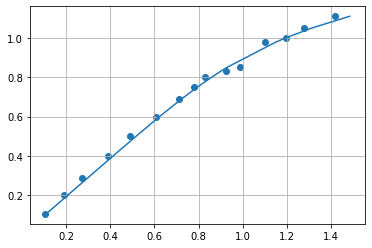

In [85]:
ag_line = If_points*bv

plt.scatter(If_points, Eg_points)
# plt.plot(If_points, ag_line)
plt.plot(k*(Eg_points + Cm*Eg_points**m), Eg_points)
plt.grid()
plt.show()

0.7654989594262225

In [111]:
def field_model(X, Eg): 
    bv, Cm, m, k = X
    If = Eg/bv + k*(Eg + Cm*Eg**m)
    return If

def MSE(X, Eg, If): 
    bv, Cm, m, k = X
    If_model = Eg/bv + k*(Eg + Cm*Eg**m)
    return np.mean((If_model - If)**2)

def calc_emfs(Ra, Xd, Xq, Xp, Vt, P, Q): 
    ia = np.sqrt(P**2 + Q**2)/Vt
    if P == 0 and Q == 0: 
        phi = 0
    elif P == 0 and not Q == 0: 
        phi = np.pi/2 * np.sign(Q)
    else: 
        phi = np.arctan(Q/P) #Phase angle between terminal voltage and armature current
    delta = np.arctan(ia*(Xq*np.cos(phi)-(Ra*np.sin(phi)))/(Vt+(Ra*ia*np.cos(phi))+Xq*ia*np.sin(phi))) #Power load angle 
    egu = Vt*np.cos(delta) + (Ra*ia*np.cos(delta+phi)) + Xd*ia*np.sin(delta+phi) 
    th = np.arctan(ia*(Xp*np.cos(phi) - Ra*np.sin(phi)) / (Vt + (Ra*ia*np.cos(phi)) + Xp*ia*np.sin(phi)) ) #Potiervinkel 
    ep = Vt*np.cos(th) + (Ra*ia*np.cos(th+phi)) + Xp*ia*np.sin(th+phi) 
    return egu, ep 
    

bv = 1.0
Cm = 0.160
m = 7 
k = 1.0308 
X = [bv, Cm, m, k]

sol = minimize(MSE, X, args=(Eg_points*Vn_kV/np.sqrt(3), If_points*If_n), method='Nelder-Mead')
bv_sol, Cm_sol, m_sol, k_sol = sol.x 
sol.x

array([26.9193011 ,  1.13261958,  1.46241485, 54.70610234])

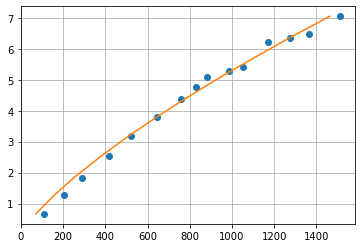

In [115]:
If_sim = field_model([bv_sol, Cm_sol, m_sol, k_sol], Eg_points*Vn_kV/np.sqrt(3)) 

plt.plot(If_points*If_n, Eg_points*Vn_kV/np.sqrt(3), 'o')
plt.plot(If_sim, Eg_points*Vn_kV/np.sqrt(3), )
plt.grid()
plt.show()

In [117]:
p, q, v = OP1.get_PQV_pu(S_base=103, V_base=11)
eg, ep = calc_emfs(Ra, Xd, Xq, Xp, OP1.V_kV*1000/np.sqrt(3), OP1.P_mw*1e6/3, OP1.Q_mvar*1e6/3)
eg = eg
ep = ep*np.sqrt(3)/11000

# If = (eg - ep)/bv_sol + k_sol*(ep + Cm_sol*ep**m_sol)
If = (eg - ep)/bv + k*(ep + Cm*ep**m)
If*If_n

1.1808551144298324e+29

In [91]:
OP1.P_mw

92.7

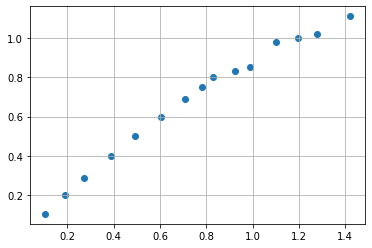